# <center>**An Analysis of the Correlates of War**  
<center>By Wesley Day

---

War has been a terrible part of the human condition for at least thousands of years. The first half of the 20th century saw the entire world engulfed in war twice, causing widespread destruction and loss of life. The second half was also filled with war and looming over it all was the possibility of nuclear armageddon. The recent [war in Ukraine](https://www.cnn.com/world/europe/ukraine) and [growing hostility between the US and China](https://www.nytimes.com/article/us-china-tensions-explained.html) has made me, and I suspect many others, worry that another terrible war on the scale of the World Wars will happen in the next couple of decades.

In this tutorial, I hope to find some correlates of war and in the process, show the data science lifecycle from start to finish. I found a great resource for this called the [Correlates of War Project](https://correlatesofwar.org/). On their website, they have several data sets that cover topics like interstate war, intrastate war, militarized interstate disputes, trade, religion, and more. All of the data sets were made to be compatible with each other, which makes our job a lot easier.

Before we begin, there are some definitions and clarifications I need to provide. An interstate war is a war between states. The requirements to be considered a state by the Correlates of War Project are "membership in the League of Nations or the United Nations, or a population of at least 500,000 and recognition (through diplomatic missions) by two major powers". Interstate war is the type of war we are going to be focusing on. A dyad is a set of two countries and a directed dyad is a set of two countries where order matters (i.e. USA and Canada is different from Canada and USA). We will be using directed dyads throughout this tutorial. In the datasets and in our analysis, countries/states will be classified by a country code (ccode) which is a unique 1-3 digit positive integer for each country. More information about this is provided in the second code block.  
If you are interested in doing your own dive into the data or would like to know more about any of the data I use here (how it was collected, coded, etc.), I encourage you to visit the Correlates of War Project website linked above.

---

In [1]:
# Importing libraries that we'll need. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import statsmodels.api as sm

In the datasets we are using, each country is associated with a country code. Here, we are reading in the csv that contains these codes and creating a dictionary so that we can access countries by their code rather than their name. This is important because the names of countries have changed over the time period we are looking at (e.g. USSR -> Russia, Ottoman Empire -> Turkey). It is important to keep this in mind during our analysis as this will show up as "Russia" having fought in WW2, for example, when really "USSR" fought in WW2. This is okay for our purposes because we are not primarily concerned about individual states but rather the quantitative things about states that are correlated with war.

In [2]:
# I used this dictionary for troubleshooting primarily. When data didn't make sense, I could
# look up the countries involved and find out what was going on.
country_codes = pd.read_csv("correlates_of_war/COW-country-codes.csv")
country_codes = country_codes.drop_duplicates()
country_codes = country_codes.set_index("CCode")
country_dict = country_codes.to_dict("index")

# The data sets that we are working with are very large. I ran into some problems
# with the kernel crashing, so deleting the DataFrames when we're done with them should help.
del country_codes

In [3]:
# Here we are checking that this worked correctly by plugging in some of
# the country codes and making sure they are associated with the right country.

print(country_dict[2]) # should be USA
print(country_dict[20]) # should be Canada
print(country_dict[365]) # should be Russia
try:
    print(country_dict[3]) # no country associated with this code, should throw a KeyError
except KeyError:
    print("Not a valid country code")

{'StateAbb': 'USA', 'StateNme': 'United States of America'}
{'StateAbb': 'CAN', 'StateNme': 'Canada'}
{'StateAbb': 'RUS', 'StateNme': 'Russia'}
Not a valid country code


In [4]:
# Now we are going to read in the rest of our csv files. Some of the files use Latin-1 encoding which
# causes problems when we try read it in with pandas as pandas assumes UTF-8 by default. To make this simpler
# I wrote a short function that will figure out the encoding. This isn't the most efficient, but it's
# not too slow and it works.
def get_encoding(filename):
    with open(filename, "rb") as f:
        return chardet.detect(f.read())["encoding"]

filename = "correlates_of_war/COW War Data/Dyadic-Interstate-War-Dataset/directed_dyadic_war.csv"
war = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/Colonial Contiguity/contcol.csv"
colonial_contiguity = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/Direct Contiguity/contdird.csv"
direct_contiguity = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/Militarized Interstate Disputes/dyadic_mid_4.02.csv"
mid = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/National Material Capabilities/NMC-60-abridged/NMC-60-abridged.csv"
nmc = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/Territorial Change/tc2018.csv"
territorial_change = pd.read_csv(filename, encoding=get_encoding(filename))

filename = "correlates_of_war/Trade/Dyadic_COW_4.0.csv"
trade = pd.read_csv(filename, encoding=get_encoding(filename))

# **Data Cleaning**

Luckily for us, the Correlates of War Project has spent a lot of time making their data as easy to use as possible, which includes interpolating missing data sometimes or indicating that the data is missing otherwise. For example, -9 typically means missing data. I've looked through the codebooks that are provided with each dataset and can say that everywhere negative integers occur, it is meant to signify data is missing or not applicable, and so we can safely replace all instances of negative integers with NaN. We do this so that these negative numbers don't affect our analysis later.

In [5]:
# Dropping all the columns we don't need. You can tell by the number of columns I'm dropping that I'm only scratching
# the surface of what can be done with this data.
nmc = nmc.drop(columns=['stateabb', 'milex', 'milper', 'irst', 'pec', 'tpop', 'upop', 'version'])

colonial_contiguity = colonial_contiguity.drop(columns=['dyad', 'statelab', 'dependl', 'statehab', 'dependh', 'version'])

direct_contiguity = direct_contiguity.drop(columns=['dyad', 'state1ab', 'state2ab', 'version'])

trade = trade.drop(columns=['importer1', 'importer2', 'smoothflow1', 'smoothflow2', 'smoothtotrade', 'spike1', 'spike2', 
                    'dip1', 'dip2', 'trdspike', 'tradedip', 'bel_lux_alt_flow1', 'bel_lux_alt_flow2', 'china_alt_flow1', 'china_alt_flow2',
                    'source1', 'source2', 'version'])

territorial_change = territorial_change.drop(columns=['month', 'gaintype', 'procedur', 'entity', 'contgain', 'area', 'pop', 'portion', 
                                 'losetype', 'contlose', 'entry', 'exit', 'number', 'indep', 'conflict', 'version'])

mid = mid.drop(columns=['disno', 'dyindex', 'namea', 'nameb', 'strtday', 'strtmnth', 'strtyr', 'endday', 'endmnth', 'endyear', 'settlmnt', 
                        'fatlev', 'highact', 'hihost', 'recip', 'noinit', 'notarg', 'sideaa', 'revstata', 'revtypea', 'fatleva', 
                        'highmcaa', 'hihosta', 'orignata', 'sideab', 'revstatb', 'revtypeb', 'fatlevb', 'highmcab', 'hihostb', 
                        'orignatb', 'rolea', 'roleb', 'dyad_rolea', 'dyad_roleb', 'durindx', 'duration', 'cumdurat', 'mid5hiact', 
                        'mid5hiacta', 'mid5hiactb', 'severity', 'severitya', 'severityb', 'ongo2014', 'new', 'change', 'changetype_1',
                        'changetype_2', 'dyad', 'abbreva', 'abbrevb', 'lastobs', 'newar', 'outcome', 'war'])

war = war.drop(columns=['warnum', 'disno', 'dyindex', 'warstrtmnth', 'warstrtday', 'warendmnth', 'warenday', 'warendyr', 'warolea', 
                        'waroleb', 'wardyadroleb', 'batdtha', 'batdthb', 'batdths', 'outcomea', 'changes_1', 'changes_2', 'durindx', 'year'])

In [6]:
# The datasets typically use -9 to mean missing value, but some use -8. Regardless,
# negative integers are codes for something and not actual data so we can safely replace
# these with NaN.
def replace_missing(df):
    return df.applymap((lambda x: np.nan if x == -9 or x == -8 else x))

war = replace_missing(war)
colonial_contiguity = replace_missing(colonial_contiguity)
direct_contiguity = replace_missing(direct_contiguity)
nmc = replace_missing(nmc)
trade = replace_missing(trade)
territorial_change = replace_missing(territorial_change)

In [7]:
# Checking to see how much missing data we have.
print(war.isna().sum())
print(colonial_contiguity.isna().sum())
print(direct_contiguity.isna().sum())
print(nmc.isna().sum())
print(trade.isna().sum())
print(territorial_change.isna().sum())

statea          0
stateb          0
warstrtyr       0
wardyadrolea    0
dtype: int64
statelno    0
conttype    0
statehno    0
begin       0
end         0
dtype: int64
state1no    0
state2no    0
year        0
conttype    0
dtype: int64
ccode    0
year     0
cinc     0
dtype: int64
ccode1         0
ccode2         0
year           0
flow1     236111
flow2     241070
dtype: int64
year        0
gainer      0
loser     137
dtype: int64


The isna().sum() tell us the number of NaN values in each column of the DataFrame. As you can see, most of our DataFrames are okay, but some (especially trade) have some missing data. We'll deal with each of these in time.

What we'd like is one DataFrame that contains entries for every directed dyad for every year. The datasets aren't always prepared like this, so we're going to have to do some processing and calculating to get the data in a form that we can use and analyze. We'll start with national military capabilities. We're going to use the [Composite Index of National Capability](https://en.wikipedia.org/wiki/Composite_Index_of_National_Capability). This is a measure of how powerful a country is. Since we're not concerned about individual countries but rather the relationship between them, we're going to calculate the percent difference between each directed dyad. Here is the equation we'll use to calculate that:

$$
\text{Percent Difference} = \left(\frac{{\text{ccode1}} - {\text{ccode2}}}{\frac{{\text{ccode1}} + {\text{ccode2}}}{2}}\right) \times 100
$$

In [8]:
# Here we are calculating the percent difference in military capabilities between each
# country and every other country for each year in the dataset (1816-2016).
# At the same time, we're building our DataFrame that will contain every directed
# dyad for every year.

# Calculates the percent difference of CINC scores between one country and
# every other country for a given year. The number will be between -100 and 100.
def percent_diff(row):
    rest = nmc[(nmc['ccode'] != row['ccode']) & (nmc['year'] == row['year'])]
    cinc_diff = row['cinc'] - rest['cinc'].values
    cinc_sum = row['cinc'] + rest['cinc'].values
    percent_diff = (cinc_diff / cinc_sum / 2) * 100
    ccode1 = np.full_like(rest['ccode'].values, row['ccode'])
    year = np.full_like(ccode1, row['year'])
    return pd.DataFrame(
        {'year': year, 'ccode1': ccode1, 'ccode2': rest['ccode'].values, 'capability_percent_diff': percent_diff})

percent_diff_df = nmc.apply(percent_diff, axis=1)
df = pd.concat(percent_diff_df.tolist(), axis=0, ignore_index=True)

del percent_diff_df, nmc

Now we're going to figure out how far each country is from another. We will use two datasets here, direct contiguity and colonial contiguity. The closeness of two countries is represented by the conttype variable, which is categorical (we'll talk about this more when we do the analysis). What each value means is described in the code block.

In [9]:
# Adding direct contiguity, both datasets cover 1816-2016. conttype:
# 1 = separated by a land or river border
# 2 = separated by <= 12 miles of water
# 3 = separated by (12, 24] miles of water or less
# 4 = separated by (24, 150] miles of water or less
# 5 = separated by (150, 400] miles of water or less
# 6 = separated by > 400 miles of water or no direct route (e.g. Afghanistan and Kazakhstan)

# In this dataset, they do not have an entry for every year. Instead, they have a begin year and an end year.
# Here we are exploding the DataFrame to have an entry for each year between the begin and end year.
# This creates some duplicate rows, which we drop.
colonial_contiguity['year'] = \
    [range(begin, end + 1) for begin, end in zip(colonial_contiguity['begin'], colonial_contiguity['end'])]
colonial_contiguity = colonial_contiguity.explode('year')
colonial_contiguity = colonial_contiguity.drop(columns=['begin', 'end'])
colonial_contiguity = colonial_contiguity.drop_duplicates()
colonial_contiguity = colonial_contiguity.rename(columns={'statelno': 'ccode1', 'statehno': 'ccode2'})

# colonial_contiguity only has one row per dyad, rather than two rows like the
# DataFrame we're building. To fix this, we just make a copy of colonial_contiguity and 
# switch the names of the columns, then concatenate them together.
colonial_contiguity = pd.concat(
    [colonial_contiguity, colonial_contiguity.rename(columns={'ccode1': 'ccode2', 'ccode2': 'ccode1'})], ignore_index=True)

direct_contiguity = direct_contiguity.rename(columns={'state1no': 'ccode1', 'state2no': 'ccode2'})

# Now we are merging our two contiguity DataFrames based on ccode1, ccode2, and year. This results
# in two conttype columns, conttype_1 and conttype_2 (that's what the suffixes= is for), conttype_1
# is the value from conttype in direct_contiguity and conttype_2 is the one from colonial_contiguity.
direct_contiguity = pd.merge(
    direct_contiguity, colonial_contiguity, on=['ccode1', 'ccode2', 'year'], how='outer', suffixes=('_1', '_2'))

# The merge will fill in NaN in conttype_1 and conttype_2 when there was not a corresponding entry
# in the other DataFrame. For example, in 1816 USA and UK did not have direct contiguity, but they did
# have a colonial contiguity through Canada. So, in this example conttype_1 would be NaN and conttype_2 would be 1.
# We are replacing these NaNs with 6, indicating no contiguity, then finding our true conttype value by taking the
# minimum of the two conttypes.
direct_contiguity = direct_contiguity.fillna(6)
direct_contiguity['conttype'] = direct_contiguity[['conttype_1', 'conttype_2']].min(axis=1)
direct_contiguity = direct_contiguity.drop(columns=['conttype_1', 'conttype_2'])

# There are multiple rows where year, ccode1, and ccode2 match but with different conttypes.
# So we have to find the minimum of these, and then drop the rest. To do this, we group by
# year, ccode1, and ccode2, then sort them so that the smallest value is the first row.
# We can then drop rows where year, ccode1, and ccode2 are equal only keeping the first as
# we know this the smallest one. This is a long operation, it takes ~40 seconds on my computer.
direct_contiguity = direct_contiguity.groupby(['year', 'ccode1', 'ccode2']).apply(lambda x: x.sort_values('conttype'))
direct_contiguity = direct_contiguity.reset_index(drop=True)
direct_contiguity = direct_contiguity.drop_duplicates(subset=['year', 'ccode1', 'ccode2'], keep='first')

# Adding conttype to our DataFrame.
# We can do outer or left merge here, as df already contains every directed dyad for every year.
# I use outer just to be safe, and then we can check that no new rows were added (indicating that
# we really do already have every directed dyad).
print(len(df))
df = pd.merge(df, direct_contiguity, on=['ccode1', 'ccode2', 'year'], how='outer')
df['conttype'] = df['conttype'].fillna(6)
print(len(df))

del direct_contiguity, colonial_contiguity

/home/wesley/anaconda3/lib/python3.9/site-packages/pandas/core/reshape/merge.py:916: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  key_col = Index(lvals).where(~mask_left, rvals)


1912350
1912350


Now we'll add trade, the variables are described below.

In [10]:
# Trade (1870-2014)
# flow1 = imports of ccode1 from ccode2 in millions of 2014 USD
# flow2 = exports of ccode1 to ccode2 in millions of 2014 USD

# Like with colonial_contiguity, this dataset only has one row for each dyad rather than two like we want.
# Fixing it in the exact same way as before, except this time we also need to switch flow1 and flow2.
trade = pd.concat([trade, trade.rename(columns={'ccode1': 'ccode2', 'ccode2': 'ccode1', 'flow1': 'flow2', 'flow2': 'flow1'})])

# Calculating imports/export each country has with another by its relative amount
# to that country's total trade in a given year as a percentage. E.g. if the US exports
# a total of $1 billion of goods in a year and exports $500 million to Canada
# then USA's export_percent with Canada is 50.
grouped = trade.groupby(['ccode1', 'year'])[['flow1', 'flow2']].transform('sum')
trade['flow1_sum'] = grouped['flow1']
trade['flow2_sum'] = grouped['flow2']
trade['import_percent'] = (trade['flow1'] / trade['flow1_sum']) * 100
trade['export_percent'] = (trade['flow2'] / trade['flow2_sum']) * 100
trade = trade.drop(columns=['flow1', 'flow1_sum', 'flow2', 'flow2_sum'])

# Adding these two columns to our DataFrame.
# Again, we'll use an outer merge to be safe, and we can check that no new rows were added.
print(len(df))
df = pd.merge(df, trade, on=['ccode1', 'ccode2', 'year'], how='outer')
print(len(df))

del trade, grouped

1912350
1912350


Next we'll add territorial change.

In [11]:
# Territorial Change (1816-2008)
# We are going to keep things simple and make this binary. If a country gained land from another country then
# we'll put a 1 in the gained_territory column, 0 otherwise. If a county lost land from another country then
# we'll put a 1 in the lost_territory column, 0 otherwise.

# Dropping rows that contain NaN, as if we don't know the year or who gained or lost territory, the data is worthless to us.
territorial_change = territorial_change.dropna()

# Here we are creating a new column in territorial_change and setting all those values to true
# and then copying territorial_change and renaming some of the columns. We then merge these with
# our main DataFrame which results in True everywhere there was a match between year, ccode1, and ccode2,
# and NaN everywhere else. We then fill in NaN with False in the two new columns we added.
territorial_change = territorial_change.rename(columns={'gainer': 'ccode1', 'loser': 'ccode2'})

# Creating a new column that contains 1 for every entry. This is so when we merge,
# we'll a 1 where there was a territorial change (as territorial_change does not have entries
# for no territorial change) and NaN elsewhere, which we can replace with 0. We'll use this technique
# a few more times after this for other variables.
territorial_change['gained_territory'] = 1

losers = territorial_change.rename(columns={'ccode1': 'ccode2', 'ccode2': 'ccode1', 'gained_territory': 'lost_territory'})

# An outer merge here would cause about 300 new rows to be added. Since all of our
# previous data have shared year/ccode1/ccode2 combinations, I'm going to do a left merge
# as filling in all the NaNs for the new rows would be impossible.
df = pd.merge(df, territorial_change, on=['ccode1', 'ccode2', 'year'], how='left')
df = pd.merge(df, losers, on=['ccode1', 'ccode2', 'year'], how='left')
df = df.drop_duplicates()
df[['gained_territory', 'lost_territory']] = df[['gained_territory', 'lost_territory']].fillna(0)

del territorial_change, losers

This data won't really help with our analysis. War is going to be a binary variable, so right now this will just tell us how correlated a change of territory is with war for the same year. But what I'm wondering is if a change in territory in the past makes war more likely (e.g. Germany losing land to France in WW1 and trying to get it back in WW2). I am going to pick a somewhat arbitrary cutoff of territory change in the last 60 years. My reasoning being that this is a long enough time where only a small minority will be able to remember a time when that territory was/wasn't a part of their country.

In [12]:
# To accomplish this, we are sorting the DataFrame by year. Then, we create
# groups based on directed dyads and take the max of the last 60 years.
# shift() moves everything up a row, ensuring that we are only looking into the
# past and not the current year. min_periods = 1 ensures that we take as many rows as 
# we can when there are not 60 previous rows (e.g. in 1820). Finally we use max()
# as there are only 1's and 0's in the gained/lost_territory columns, giving us another
# binary variable in gained/lost_in_past. We then reset the index to keep things organized.
df = df.sort_values('year').reset_index(drop=True)
df['gained_in_past'] = df.groupby(['ccode1', 'ccode2'])['gained_territory'].apply(
    lambda grp: grp.shift().rolling(61, min_periods=1).max()).reset_index(drop=True)
df['gained_in_past'] = df['gained_in_past'].fillna(0)
df['lost_in_past'] = df.groupby(['ccode1', 'ccode2'])['lost_territory'].apply(
    lambda grp: grp.shift().rolling(61, min_periods=1).max()).reset_index(drop=True)
df['lost_in_past'] = df['lost_in_past'].fillna(0)

# We can now drop the gained/lost_territory columns.
df = df.drop(columns=['gained_territory', 'lost_territory'])

Next we're going to add militarized interstate disputes (MIDs).

In [13]:
# Militarized Interstate Disputes (1816-2014)
mid = mid.rename(columns={'statea': 'ccode1', 'stateb': 'ccode2'})
mid['mid'] = 1

# Here we expect duplicate rows. We'll get a row for each MID that occured in a year.
# We'll use this in the next code block to combine this into a new column for the number
# of MIDs that occured in a year.
print(len(df))
df = pd.merge(df, mid, on=['year', 'ccode1', 'ccode2'], how='outer')
print(len(df))

del mid

1912350
1913420


In [14]:
# Counting the number of MIDs in each year for each directed dyad.
df2 = df[df.duplicated(subset=['year', 'ccode1', 'ccode2'], keep=False)][['year', 'ccode1', 'ccode2', 'mid']]
df2['mids'] = df2.groupby(['year', 'ccode1', 'ccode2'])['mid'].transform('count')
df2 = df2.drop(columns=['mid']).drop_duplicates()
df = df.drop(columns=['mid'])
df = pd.merge(df, df2, on=['year', 'ccode1', 'ccode2'], how='left')
df = df.drop_duplicates()
df['mids'] = df['mids'].fillna(0)

del df2

In [15]:
# The MIDs dataset added some rows that did not have a corresponding row in our DataFrame.
# Since we don't have any other data in those rows, we'll just have to drop them.
df = df.dropna(subset=['capability_percent_diff', 'conttype', 'gained_in_past', 'lost_in_past'])

# Here, we want a rolling count of MIDs from the past so many years.
# I'm going to pick another arbitary cutoff (this one more arbitrary than the last)
# of 5 years.
df = df.sort_values('year').reset_index(drop=True)

df['mids_past5'] = df.groupby(['ccode1', 'ccode2'])['mids'].apply(
    lambda grp: grp.shift().rolling(6, min_periods=1).sum()).reset_index(drop=True)
df['mids_past5'] = df['mids_past5'].fillna(0)

Finally we're going to add war. The Correlates of War Project has their for war. They define it as "sustained combat involving regular armed forces on both sides and 1,000 battle-related fatalities among all of the system members involved" and a war participant is a country with "a minimum of 100 fatalities or a minimum of 1,000 armed personnel engaged in active combat".

In [16]:
# War (1816-2010)
# The dataset already has directed dyads for every year (e.g. war between a and b that lasted from 1999-2000 has 4 entries)

war = war.rename(columns={'statea': 'ccode1', 'stateb': 'ccode2', 'warstrtyr': 'year', 'wardyadrolea': 'c1_initiated'})
war['at_war'] = 1

# There are some duplicated rows because we are using the start year of each war.
# In the original dataset, there is an entry for every year the war is going on.
# So if a war lasted for 3 years, we have 3 rows that are the same.
war = war.drop_duplicates()

# 3 in the original column ('wardyadrolea') indicates that ccode1 was the target
war['c1_initiated'] = war['c1_initiated'].replace(3, 0)
war = war.reset_index(drop=True)

# There is one instance of duplicate row with different c1_initiated values.
print(war.iloc[532])
print(war.iloc[533])

# To resolve this, I looked at the what the value was for the reverse country codes
# and kept the row with opposite value.
print(war.iloc[530])
war = war.drop(533)

ccode1           560
ccode2           540
year            1975
c1_initiated       1
at_war             1
Name: 532, dtype: int64
ccode1           560
ccode2           540
year            1975
c1_initiated       0
at_war             1
Name: 533, dtype: int64
ccode1           540
ccode2           560
year            1975
c1_initiated       0
at_war             1
Name: 530, dtype: int64


In [17]:
# Merging with our DataFrame, dropping duplicates, and seeing if anything was added.
print(len(df))
df = pd.merge(df, war, on=['ccode1', 'ccode2', 'year'], how='outer')
df = df.drop_duplicates()
df['at_war'] = df['at_war'].fillna(0)
print(len(df))

del war

1912350
1912350


In [18]:
# Like with territorial change, we're going to make a column for if two countries were at war 
# in the past 60 years. We're doing this in the exact same way.
df = df.sort_values('year').reset_index(drop=True)
df['war_in_past'] = df.groupby(['ccode1', 'ccode2'])['at_war'].apply(
    lambda grp: grp.shift().rolling(61, min_periods=1).max()).reset_index(drop=True)
df['war_in_past'] = df['war_in_past'].fillna(0)
df = df.drop(columns=['at_war'])

Final bit of data cleaning before we start the analysis.

In [19]:
# We're filling in NaN values in c1_inititated to 0 because NaN means there was 
# not an entry in the war DataFrame corresponding to that year, meaning that a war 
# did not begin between these two countries during this year.
df['c1_initiated'] = df['c1_initiated'].fillna(0)

# Making sure all our variables that should be integers are.
df[['year', 'ccode1', 'ccode2', 'conttype', 'gained_in_past', 'lost_in_past', 'c1_initiated', 'war_in_past', 'mids_past5']] = \
    df[['year', 'ccode1', 'ccode2', 'conttype', 'gained_in_past', 'lost_in_past', 'c1_initiated', 'war_in_past', 'mids_past5']].astype(int)

In [20]:
# War data is only until 2010, since this is our dependent variable, we can drop everything after this year.
df = df[df['year'] <= 2010]
print(df.isna().sum())

year                            0
ccode1                          0
ccode2                          0
capability_percent_diff         0
conttype                        0
import_percent             511593
export_percent             511639
gained_in_past                  0
lost_in_past                    0
mids                            0
mids_past5                      0
c1_initiated                    0
war_in_past                     0
dtype: int64


In [21]:
# We have a lot of NaNs in the trade columns. A lot of these are caused by the trade dataset being between 1870-2014 rather than
# 1816-2016. So we can create a new DataFrame containing only these rows.
df_1870 = df[df['year'] >= 1870]

# Now lets check how much is still missing.
print(df_1870.isna().sum())

year                            0
ccode1                          0
ccode2                          0
capability_percent_diff         0
conttype                        0
import_percent             449653
export_percent             449699
gained_in_past                  0
lost_in_past                    0
mids                            0
mids_past5                      0
c1_initiated                    0
war_in_past                     0
dtype: int64


In [22]:
# Checking how many rows are missing data as a percent of the whole DataFrame.
print(df_1870['export_percent'].isna().sum() / len(df_1870) * 100)

27.700547605994714


As you can see there are still a lot of missing data in the trade columns and more than a quarter of our rows are missing data. We're just going to drop this for now and do the analysis. However, I'm not confident that this won't bias the data as I'm not sure if the data is missing at random (and losing a quarter of our data is definitely not ideal). The documentation for the trade data does not specify why data is missing other than it was just not available from their sources. The other option is to fill in missing data with 0, but this would not be right. The maintainers of this data explicitly say, "We do not equate an absence of trade data with an absence of trade.". So we'll go ahead and do an analysis with this data and another with the data from 1816-2010 but without trade.

In [23]:
df_1870 = df_1870.dropna()

# **Analysis**

We're going to create two [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) models using the statsmodels.api library. A logistic regression model is done when the dependent variable is a binary outcome. This is the case for us, our dependent variable is whether country 1 initiated a war or not.

In [24]:
# Creating our first model with the trade data. Notice C(conttype) in the formula, this tells the function to
# treat conttype as a categorical variable rather than a continuous one. The function will be able to determine this
# for our binary variables like gained_in_past.
model_1870 = sm.formula.logit(
    'c1_initiated ~ year + capability_percent_diff + C(conttype) + import_percent + export_percent + gained_in_past + lost_in_past + war_in_past + mids_past5', 
    data=df_1870).fit()
print(model_1870.summary())

Optimization terminated successfully.
         Current function value: 0.000932
         Iterations 15
                           Logit Regression Results                           
Dep. Variable:           c1_initiated   No. Observations:              1126205
Model:                          Logit   Df Residuals:                  1126191
Method:                           MLE   Df Model:                           13
Date:                Fri, 12 May 2023   Pseudo R-squ.:                  0.1628
Time:                        02:52:46   Log-Likelihood:                -1050.0
converged:                       True   LL-Null:                       -1254.1
Covariance Type:            nonrobust   LLR p-value:                 4.086e-79
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  36.7989      5.310      6.930      0.000      26.391  

What sticks out to me inititally when looking at this is that export_percent has a significant effect (p < 0.05) but import_percent does not. This seems odd. Since I was already skeptical of this data before, I am just going to use the model without trade. This is shown below.

In [30]:
model = sm.formula.logit(
    'c1_initiated ~ year + capability_percent_diff + C(conttype) + gained_in_past + lost_in_past + war_in_past + mids_past5', 
    data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.001396
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:           c1_initiated   No. Observations:              1685370
Model:                          Logit   Df Residuals:                  1685358
Method:                           MLE   Df Model:                           11
Date:                Fri, 12 May 2023   Pseudo R-squ.:                  0.1662
Time:                        02:54:54   Log-Likelihood:                -2352.1
converged:                       True   LL-Null:                       -2820.9
Covariance Type:            nonrobust   LLR p-value:                4.892e-194
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  20.5388      2.097      9.794      0.000      16.429  

Let's first look at the pseudo R-squared. This number tells us the goodness of fit of our model. In this model, it is 0.1662. In the previous model it was 0.1628. This suggests that the second model is better at predicting our dependent variable (though not by much), which is another reason why we'll focus on this one. Now let's look at LLR p-value. LLR is the Log-Likelihood ratio and is the ratio between Log-Likelihood and LL-Null. The p-value is obtained by doing a statistical significance test. In our case, the value is incredibly small meaning we can be extremely confident that our model is better at predicting a country initiating war than the null model (the model that assumes no relationship between our variables and c1_initiated). As we move into the variables, I should preface by explaining what each number means in general. The coefficients are similar to what they mean in a linear regression. That is, that positive numbers represent a positive correlation and negative numbers represent a negative correlation. A larger magnitude represents a stronger relationship. However, since the dependent variable is binary, everything is in probability. So a positive coefficient for a continuous variable means that as that variable increases, the probability of the event occuring increases. The other number we are primarly concerned with is P>|z|, which is the p-value. This number is the probability of obtaining results at least this extreme. When this number is < 0.05 it means that there is less than a 5% chance that we've obtained these results due to chance and that the results are statistically significant.

Now let's look at each of the variables, starting with conttype. Conttype is a categorical variable, so each category has to be compared to a reference category, in this case 1. We can see that as conttype increases (meaning distance between countries increases), the coefficient decreases. What does this mean? Let's take conttype = 6 as an example, the coefficient is -2.3744. This means that being separated by > 400 miles of water is associated with a decrease in the log-odds of ccode1 initiating a war against ccode2 by -2.3744 compared to ccode1 and ccode2 sharing a land border. Of all of the conttypes, only 5 and 6 are significantly different from conttype = 1. This makes sense, that the further away two countries are, the less likely they are to go to war.

Moving onto the other variables, we can look at year next. Year is a statistically significant negative predictor of ccode1 initiating a war with ccode2, though not a very strong one. This is still good news and also conforms with what I would expect, that as time has gone on war has become less likely. Next is difference in capabilities. I expected this to be a strong predictor, however there is very little correlation and the effect is not statistically significant. Next is gained/lost territory in the past. Gained is not statistically significant but lost is and it has a small positive correlation. This makes sense to me, I gave the example of Germany and France earlier. Germany lost territory to France in WW1, and tried to get it back in WW2. Next is war in the past. This is the strongest predictor we have with a coefficient of 1.4382 and a p-value of 0.000. Lastly we have the number of militarized disputes in the past 5 years, which is also positively correlated and statistically significant.

We can try to graph some our variables. Since our data set is so large and war so rare, we won't be able to see much. But for the purposes of the tutorial, I'll demonstrate how to create some simple graphs using matplotlib.

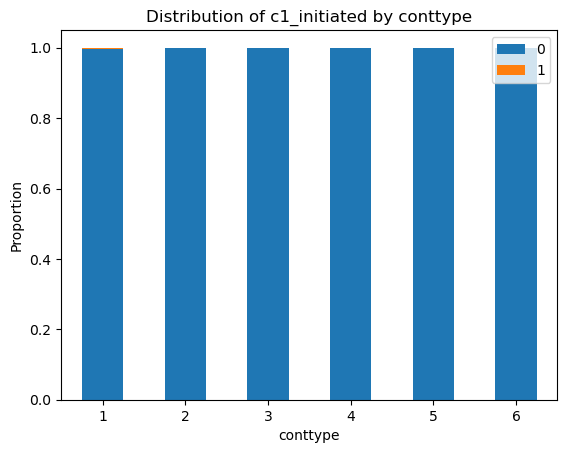

<Figure size 800x600 with 0 Axes>

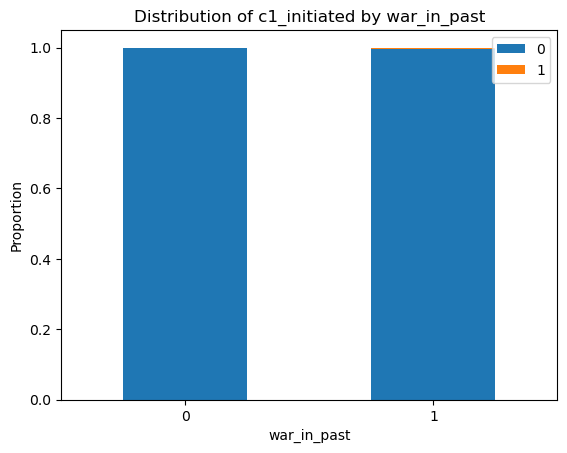

In [26]:
# Making two stacked bar graphs. One for conttype and one for war_in_past. 
grouped = df.groupby('conttype')['c1_initiated'].value_counts(normalize=True).unstack()
grouped.plot(kind='bar', stacked=True)
plt.xlabel('conttype')
plt.ylabel('Proportion')
plt.title('Distribution of c1_initiated by conttype')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
grouped = df.groupby('war_in_past')['c1_initiated'].value_counts(normalize=True).unstack()
grouped.plot(kind='bar', stacked=True)
plt.xlabel('war_in_past')
plt.ylabel('Proportion')
plt.title('Distribution of c1_initiated by war_in_past')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

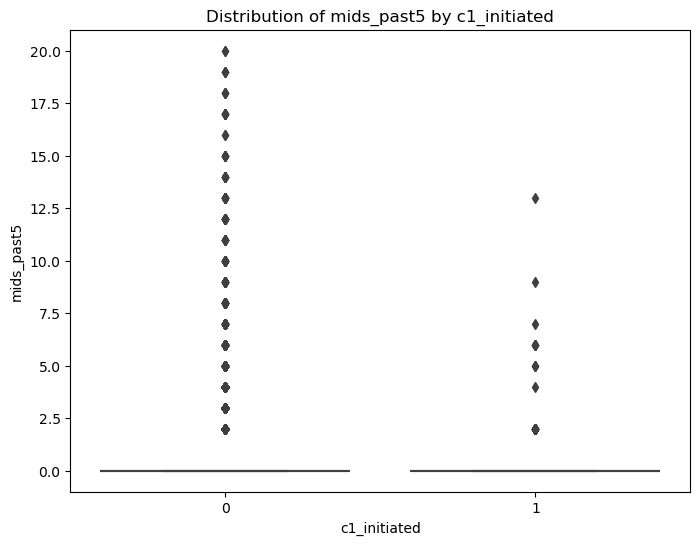

In [27]:
# Making a box plot of mids_past5.
plt.figure(figsize=(8, 6))
sns.boxplot(x='c1_initiated', y='mids_past5', data=df)
plt.xlabel('c1_initiated')
plt.ylabel('mids_past5')
plt.title('Distribution of mids_past5 by c1_initiated')
plt.show()

There are so many 0's that everything else is an outlier. We'll try again, this time removing all the rows where mids_past5 contains a 0.

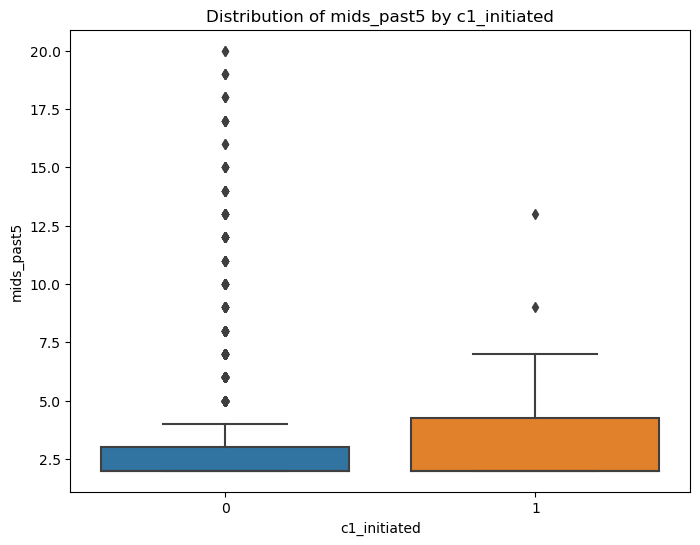

In [28]:
# Removing 0 
df2 = df.drop(df[df['mids_past5'] == 0].index)

plt.figure(figsize=(8, 6))
sns.boxplot(x='c1_initiated', y='mids_past5', data=df2)
plt.xlabel('c1_initiated')
plt.ylabel('mids_past5')
plt.title('Distribution of mids_past5 by c1_initiated')
plt.show()

In [29]:
# Machine Learning Ideas

# Feature selection: You can use ML algorithms to determine which features (or predictor variables) are the most 
# important for predicting the binary response variable c1_initiated. This can help you identify the key factors 
# that contribute to the likelihood of war initiation.

# Clustering: You can use clustering algorithms to group countries together based on their similarities in terms 
# of the predictor variables. This can help you identify groups of countries that are more likely to engage in wars, 
# and potentially identify underlying factors that contribute to these similarities.